# NLSA: Monthly Images - RCP45 model

In [1]:
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import pandas as pd
import warnings
import scripts.helper as helper
import scripts.matrix_helper as mat_helper
from scipy.sparse.linalg import eigs
from scipy import signal
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm_notebook
from scipy.stats.stats import pearsonr
import pickle

#Cool stuff -> Every notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load monthly data

In [19]:
climate_change = np.array(pickle.load(open("anthropogenicForcing_rcp45.pkl", "rb" )))

In [3]:
avg = np.load('Monthly_avg_MPI_ESM_rcp45.npy', mmap_mode='r')

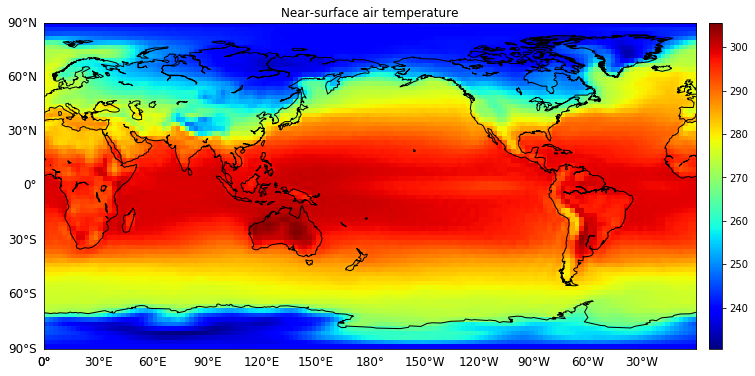

In [4]:
fig = plt.figure(figsize=(16,6))
long = [0, 360]
lat = [-90, 90]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    map = Basemap(projection = 'cyl', llcrnrlat = lat[0], llcrnrlon = long[0], urcrnrlat = lat[1], urcrnrlon = long[1])
    map.drawcoastlines()
    map.drawparallels( np.arange(-90,90.01,30.0), labels = [1,0,0,0], fontsize = 12, linewidth = 0)
    map.drawmeridians( np.arange(0.,360.,30.), labels = [0,0,0,1], fontsize = 12, linewidth = 0)

    h = map.imshow(avg[0,:], cmap = 'jet', interpolation = 'none', animated = True)
    map.colorbar(h, size = "2%")#, pad="40%", ticks = range(cmin, cmax + 1, cint))
    plt.title("Near-surface air temperature")

## Precompute pairwise distances

In [5]:
precomputed_dist = mat_helper.precompute_distances(avg)

In [6]:
np.save('Monthly_precomputed_dist_rcp45', precomputed_dist)

## Build Distance Matrix

In [7]:
D_mat = mat_helper.build_distance_mat_precomputed(precomputed_dist, 60)

In [8]:
np.save('monthly_D_mat_5y_rcp45', D_mat)

## Select K-nn

In [9]:
D_mat = np.load('monthly_D_mat_5y_rcp45.npy')

In [10]:
D_mat.shape

(2713, 2713)

In [11]:
2713/2

1356.5

In [12]:
M = helper.select_k_closest(D_mat, 1357)

## Apply NLSA Kernel

In [13]:
K = mat_helper.build_nlsa_kernel(M, 2)

## Build Laplace-Beltrami Operator

In [14]:
L = mat_helper.build_Laplace_Beltrami_operator(K)

## Eigenvector Decomposition

In [15]:
# Eigendecomposition of the Laplacian - keep only the real part
w_k, v_k = eigs(L, k=100, which='SM')
w_k = np.real(w_k)
v_k = np.real(v_k)

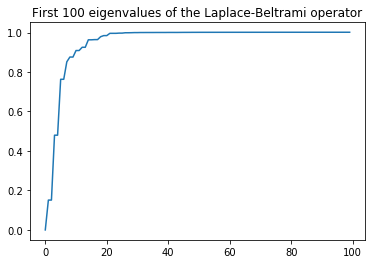

In [16]:
# Eigenvalue plot
plt.title('First 100 eigenvalues of the Laplace-Beltrami operator')
plt.plot(w_k[:100])
plt.show()

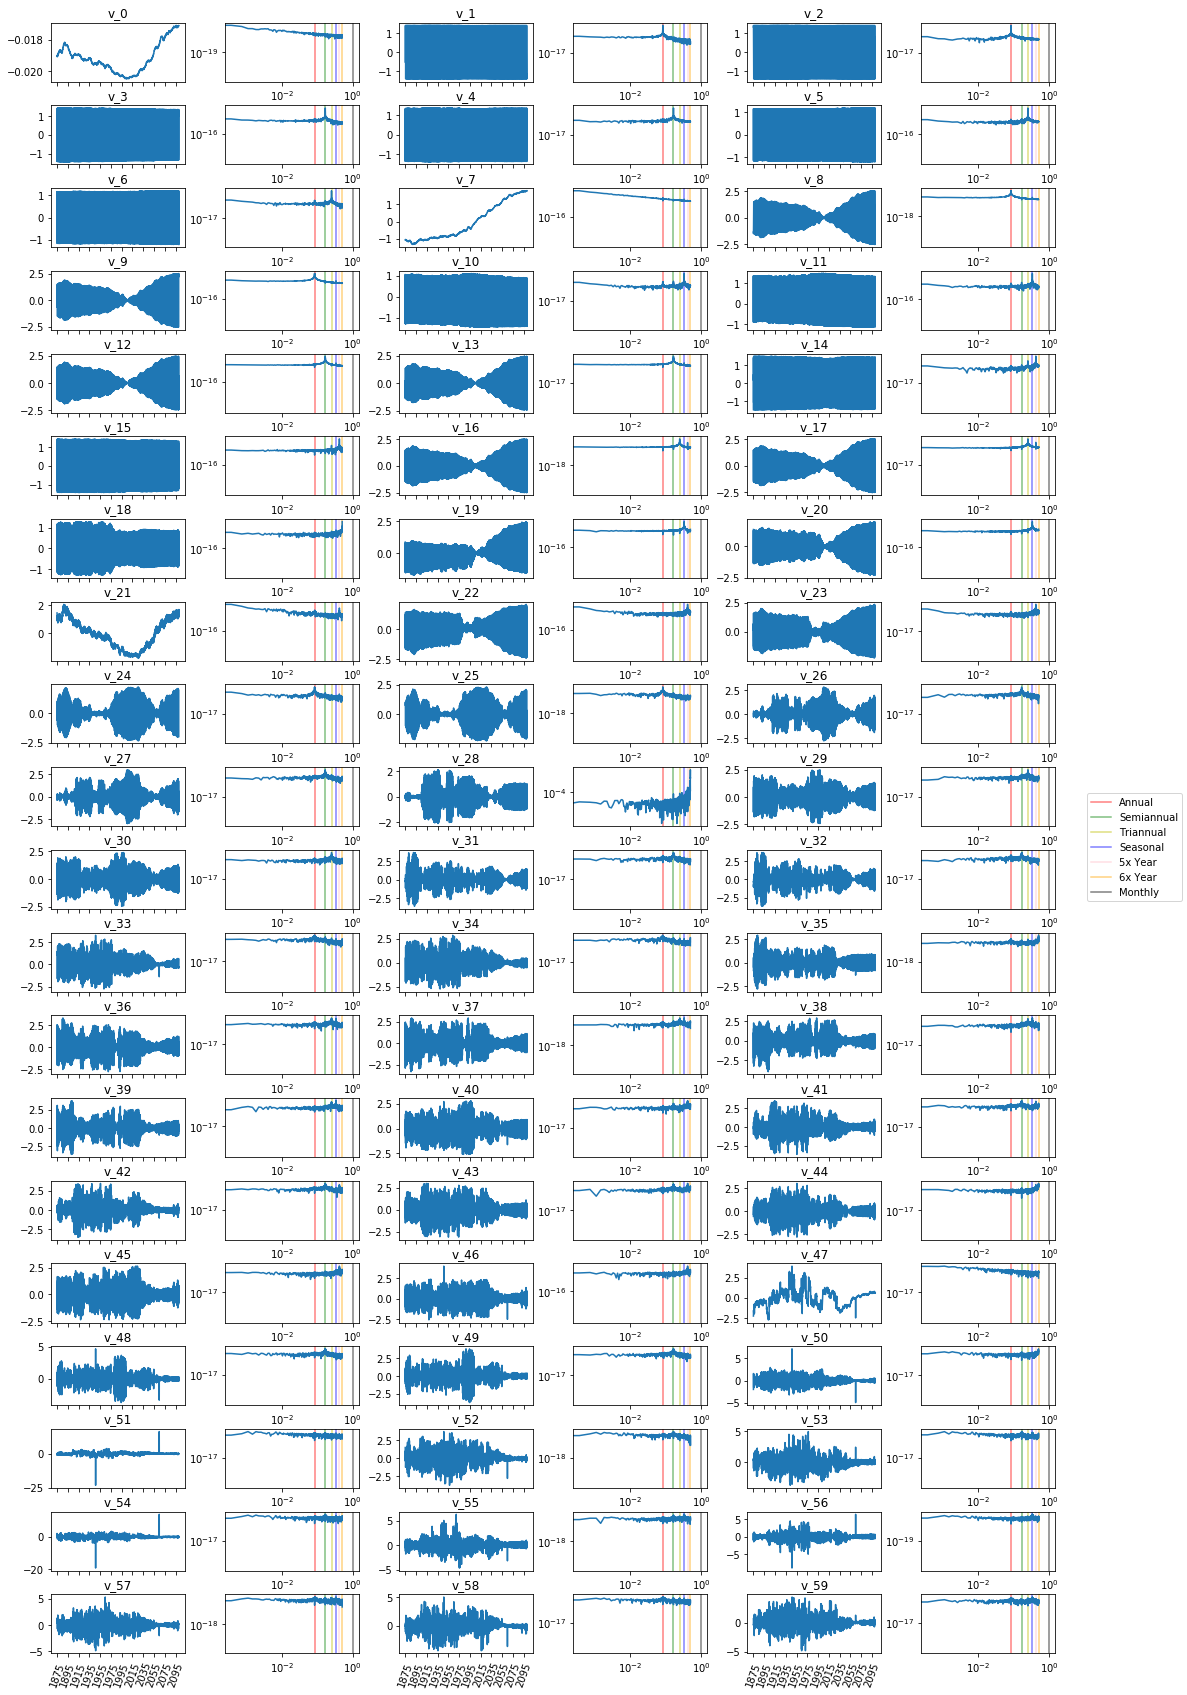

In [18]:
# Frequencies plot
list_vector = [i for i in range(0, 60)]
my_xticks = np.arange(1875, 2106, 20)
fig = plt.figure(figsize=(18,30))
ind = 1
for i in list_vector:
    ax = plt.subplot(20, 6, ind)
    ax.set_xticks(np.arange(0, len(v_k[:, 0]), 240))
    
    if i == 57 or i == 58 or i == 59:
        ax.set_xticklabels(my_xticks, rotation='70')
    else:
        ax.set_xticklabels(['', '', '', '', ''], rotation='70')
          
    ind += 1
    plt.title('v_' + str(i))
    if i != 0:
        plt.plot(v_k[:, i]/v_k[:, 0])
    else:
        plt.plot(v_k[:, i])
    
    plt.subplot(20, 6, ind)
    ind += 1
    f, Pxx_den = signal.periodogram(np.real(v_k[:, i]))
    l2 = plt.axvline(x=1/12, color='r', alpha=0.5) #1y
    l3 = plt.axvline(x=1/(12/2), color='g', alpha=0.5) #6m
    l4 = plt.axvline(x=1/(12/3), color='y', alpha=0.5) #4m
    l5 = plt.axvline(x=1/(12/4), color='b', alpha=0.5) #3m
    l6 = plt.axvline(x=1/(12/5), color='pink', alpha=0.5) #2.4m
    l7 = plt.axvline(x=1/(12/6), color='orange', alpha=0.5) #2m
    l8 = plt.axvline(x=1/(12/12), color='black', alpha=0.5)
    plt.loglog(f, Pxx_den)
    
plt.subplots_adjust(hspace=0.4, wspace = 0.3)
fig.legend((l2, l3, l4, l5, l6, l7, l8), ('Annual', 'Semiannual', 'Triannual', 'Seasonal', '5x Year', '6x Year', 'Monthly'), 'center right')
plt.show()

In [21]:
curve = v_k[:, 7]/v_k[:, 0]
inter = np.interp(curve, (curve.min(), curve.max()), (climate_change.min(), climate_change.max()))
inter = inter[1::12]
inter = np.insert(inter, 0, [inter[0]]*5)

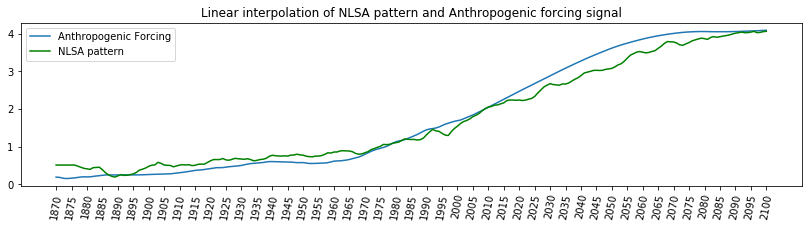

In [22]:
fig = plt.figure(figsize=(14,3))
my_xticks = np.arange(1870, 2101, 5)
ax1 = fig.add_subplot(111)
ax1.set_xticks(np.arange(0, len(inter), 5))
ax1.set_xticklabels(my_xticks, rotation='80')
cc = plt.plot(climate_change)
l = plt.plot(inter, color='g')
plt.title('Linear interpolation of NLSA pattern and Anthropogenic forcing signal')
plt.legend(('Anthropogenic Forcing', 'NLSA pattern'), loc='upper left')
plt.show()

In [23]:
# Computes linear weight moving average for the given period
def linear_weight_moving_average(signal, period):
    buffer = [np.nan] * period
    for i in range(period, len(signal)):
        buffer.append(
            (signal[i - period : i] * (np.arange(period) + 1)).sum() / (np.arange(period) + 1).sum())
    return buffer

In [24]:
m = linear_weight_moving_average(curve, 12)
m = np.array(m)
m = m[12:]
m_int = np.interp(m, (m.min(), m.max()), (climate_change.min(), climate_change.max()))
m_int = m_int[1::12]
m_int = np.insert(m_int, 0, [m_int[0]]*6)

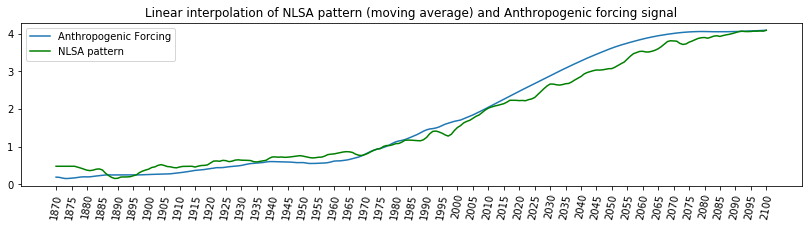

In [26]:
fig = plt.figure(figsize=(14,3))
my_xticks = np.arange(1870, 2101, 5)
ax1 = fig.add_subplot(111)
ax1.set_xticks(np.arange(0, len(m_int), 5))
ax1.set_xticklabels(my_xticks, rotation='80')
plt.plot(climate_change)
plt.plot(m_int, color='g')
plt.title('Linear interpolation of NLSA pattern (moving average) and Anthropogenic forcing signal')
plt.legend(('Anthropogenic Forcing', 'NLSA pattern'), loc='upper left')
plt.show()
plt.show()

In [27]:
pearsonr(climate_change, m_int)

(0.9943743530530765, 2.796340727402708e-225)

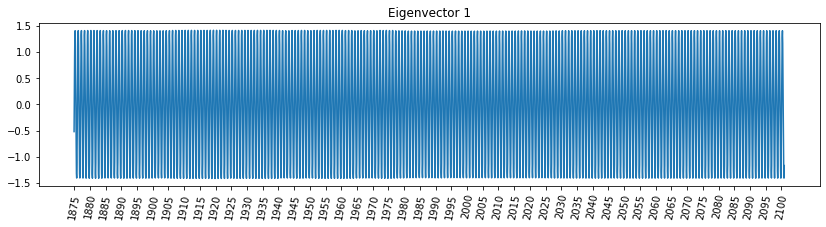

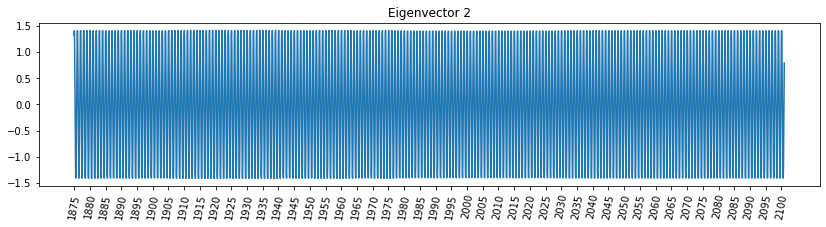

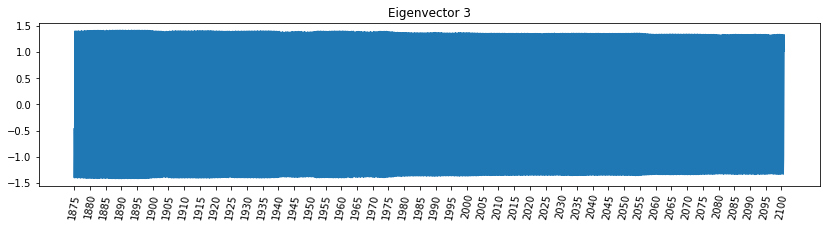

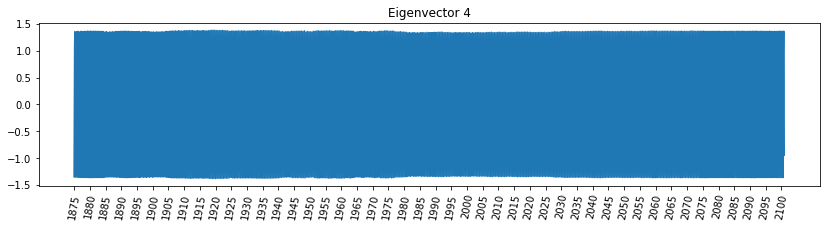

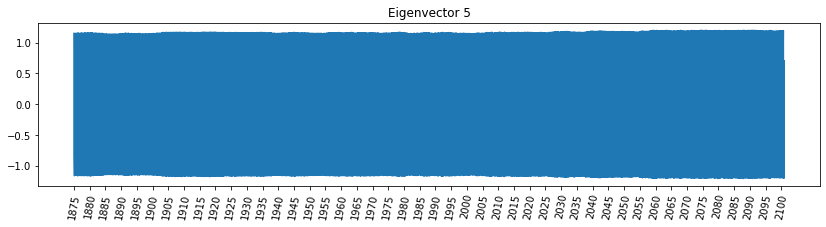

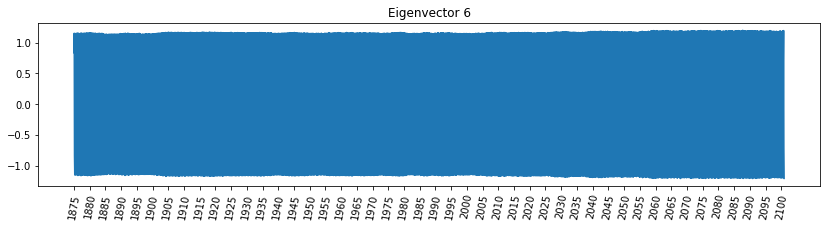

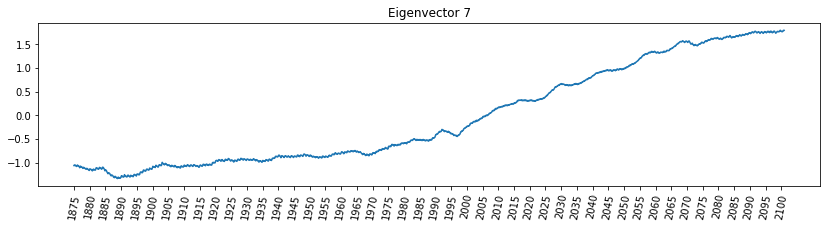

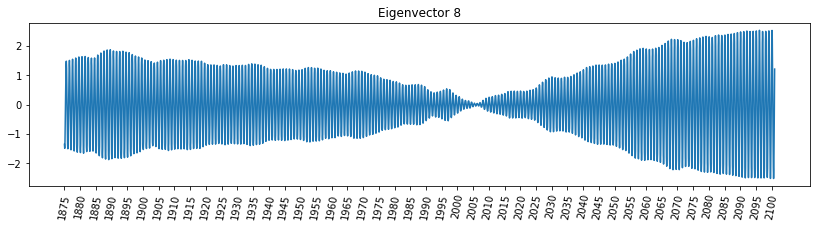

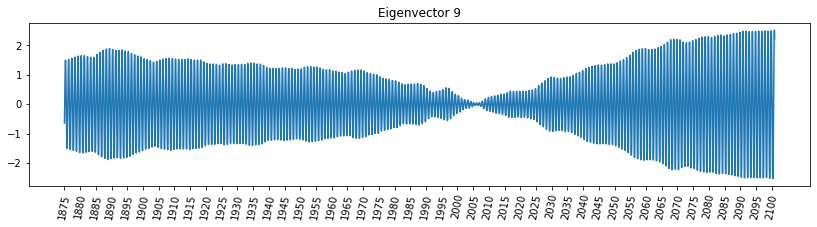

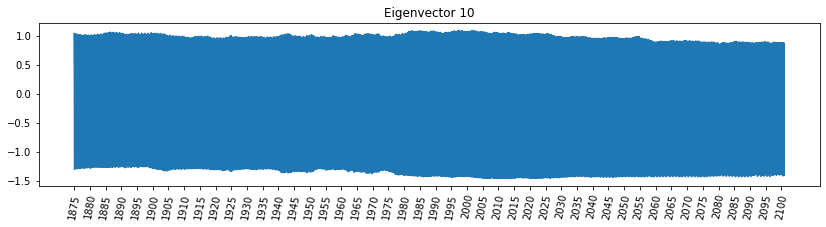

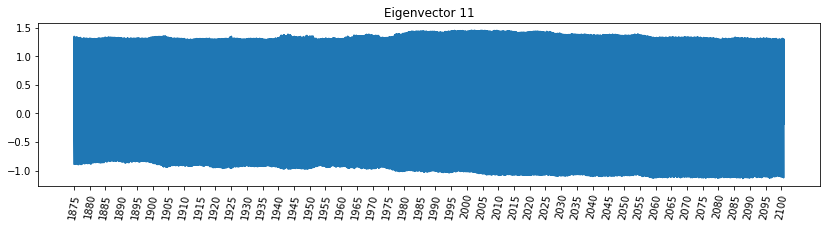

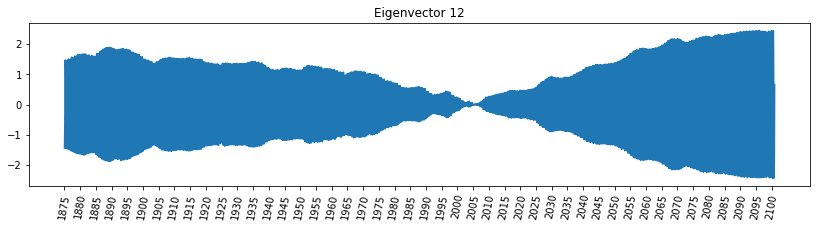

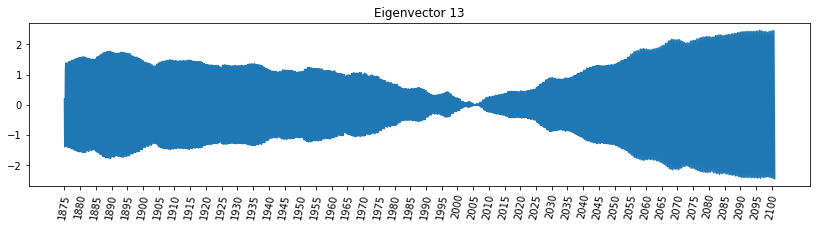

KeyboardInterrupt: 

In [20]:
for i in range(1, 100):
    fig = plt.figure(figsize=(14,3))
    my_xticks = np.arange(1875, 2101, 5)
    ax1 = fig.add_subplot(111)
    ax1.set_xticks(np.arange(0, len(v_k[:, 0]), 12*5))
    ax1.set_xticklabels(my_xticks, rotation='80')
    plt.title('Eigenvector ' + str(i))
    plt.plot(v_k[:, i]/v_k[:, 0])
    plt.show()

## Reconstruction

In [28]:
# Load original data for projection
d_data = np.load('Monthly_avg_MPI_ESM_rcp45.npy', mmap_mode='r')

In [29]:
normalized_data = d_data.reshape(d_data.shape[0], d_data.shape[1]*d_data.shape[2])   

In [30]:
normalized_data = normalized_data - np.mean(normalized_data, axis=0)

In [31]:
d_data = np.reshape(normalized_data, (d_data.shape[0], d_data.shape[1], d_data.shape[2]))

In [32]:
d_data.shape

(2772, 72, 144)

In [36]:
chosen_vec = v_k[:, 7]/v_k[:, 0]
size_vec = len(chosen_vec)
resized_data = d_data[(d_data.shape[0] - size_vec):,:]
resized_data = resized_data.reshape(resized_data.shape[0], resized_data.shape[1]*resized_data.shape[2])
X = resized_data.T
s_pattern = X @ chosen_vec
spp = np.reshape(s_pattern,(-1, 72*144))
vec = np.reshape(np.real(chosen_vec), (-1, size_vec))
Y = spp.T @ vec
Z = Y.T
Z = np.reshape(Z, (size_vec, 72, 144))

In [37]:
# Interpolation to keep scale -1, 1
frames = np.interp(Z, (Z.min(), Z.max()), (-1, 1))

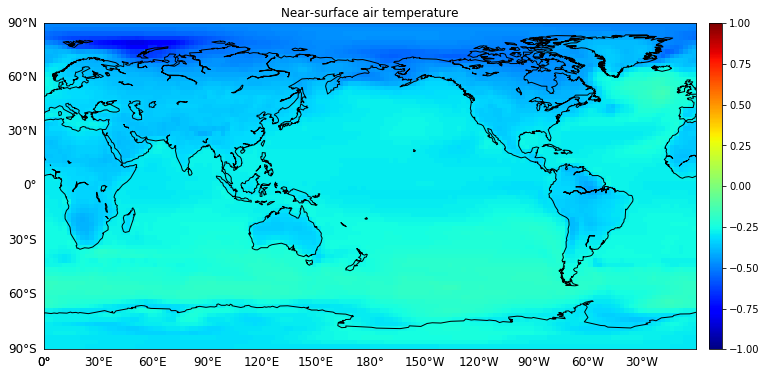

In [38]:
fig = plt.figure(figsize=(16,6))
long = [0, 360]
lat = [-90, 90]


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    map = Basemap(projection = 'cyl', llcrnrlat = lat[0], llcrnrlon = long[0], urcrnrlat = lat[1], urcrnrlon = long[1])
    map.drawcoastlines()
    map.drawparallels( np.arange(-90,90.01,30.0), labels = [1,0,0,0], fontsize = 12, linewidth = 0)
    map.drawmeridians( np.arange(0.,360.,30.), labels = [0,0,0,1], fontsize = 12, linewidth = 0)
    
    h = map.imshow(frames[1, :], cmap = 'jet', interpolation = 'none', animated = True)
    #plt.clim(-np.std(test), np.std(test))
    plt.clim(np.min(frames), np.max(frames))
    map.colorbar(h, size = "2%")#, pad="40%", ticks = range(cmin, cmax + 1, cint))
    plt.title("Near-surface air temperature")

In [39]:
plt.rcParams['animation.ffmpeg_path'] = '/Users/Alexis/anaconda/bin/ffmpeg'

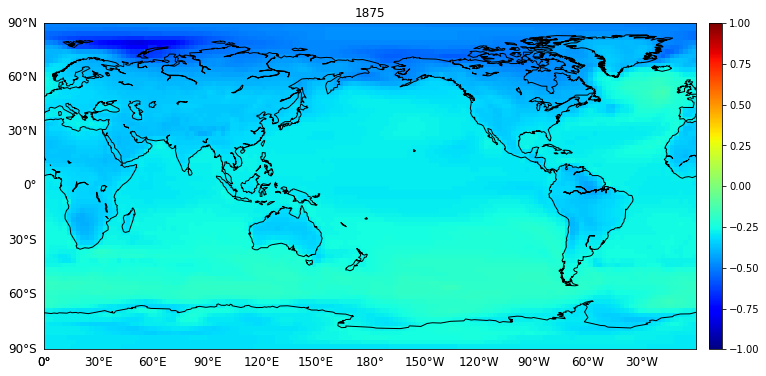

In [40]:
anim = helper.make_animation(frames, frames.shape[0], min_max=True)

In [41]:
helper.save_as_vid(anim, 'Monthly_anthropogenic_interp_rcp45.mp4', fps=25)